## Multi-scale Residual Dense Network

---



## The below network I am going to implement.

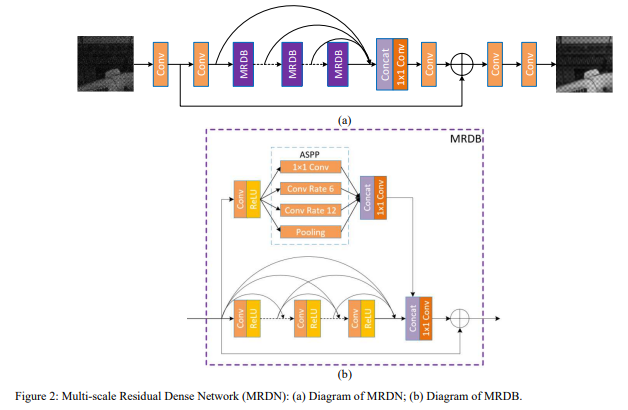

In [ ]:
load_img('/content/drive/MyDrive/Colab Notebooks/noise_clean_data/MRDN.PNG')

Related papers<br>
https://arxiv.org/pdf/2005.04117.pdf    this paper presents more than 10 architectures used for real world image denoising as part of competion in 2020. I am using architecture which won the second rank .<br> 

Research paper  I am using the architecture from can be found in the below link<br>
https://openaccess.thecvf.com/content_CVPRW_2020/papers/w31/Bao_Real_Image_Denoising_Based_on_Multi-Scale_Residual_Dense_Block_and_CVPRW_2020_paper.pdf


#### Explanation<br>
Real Image Denoising based on Multi-scale Residual Dense Block.  MRDN architecture is proposed by the Samsung SLSI MSL team in the competion 'NTIRE 2020 Challenge on Real Image Denoising'.<br>

The Multi-scale Residual Dense Network (MRDN) is 
based on a new basic module, the Multi-scale Residual 
Dense Block (MRDB), as shown in Fig. 2 (a). MRDB 
combines multi-scale features from the ASPP and other 
features from the traditional residual dense block (RDB). 
As shown in Fig. 2 (b), the ASPP  contains four 
parallel network blocks including conv 1×1, conv Rate 6, 
conv Rate 12 and pooling. The conv Rate 6 and conv Rate 
12 denote the 3×3 dilated convolutions with the dilation rate 
of 6 and 12, respectively. Conv Rate 6, conv Rate 12 and 
image pooling can well capture the multi-scale features of 
the block input. The features outputted from the ASPP are 
concatenated and compressed to be combined with other 
features from the RDB. To have a seamless local residual 
connection, this concatenated feature is compressed with 
another conv 1×1 before an element-wise adder. 
The output of the MRDB preserves the same number of 
channels of its input to avoid the exponential complexity 
increase. With the MRDB as a building module, the MRDN 
constructs the network using the similar way as the residual 
dense network (RDN) by cascading the MRDBs with 
dense connections. Specifically, the outputs of the MRDBs 
are concatenated and compressed with a conv 1×1, and a 
global residual connection is adopted to obtain clean 
features. 



In [ ]:
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input,Conv2D
from keras import backend as K
import numpy as np
from keras.layers import BatchNormalization,Activation,Subtract,Add,concatenate,multiply,Concatenate
from keras.layers import Conv2D, MaxPooling2D,Dropout,GlobalAveragePooling2D,PReLU,Reshape
from keras.optimizers import Adam
import tensorflow.keras.backend as K
import keras
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
from tensorflow.image import psnr
from tensorflow.image import ssim 
from keras.callbacks import  LearningRateScheduler,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
import glob
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import os
from tqdm.notebook import tqdm
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from skimage.util import img_as_ubyte
from tensorflow.keras.layers import Layer




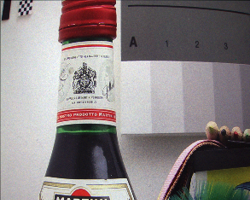

In [ ]:
array_to_img(img_to_array(load_img(root_path+'/resized_test_clean/a1.bmp'))[0:200,0:250])

In [ ]:
#mounting the google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#os.chdir('/content/drive/MyDrive/Colab Notebooks/noise_clean_data')

In [ ]:
#current directory
os.chdir('/content')
root_path='/content'
#root_path='/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset'
#os.chdir('/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset')

In [ ]:
#This function used to download from my google drive to colab disk
#https://stackoverflow.com/questions/48735600/file-download-from-google-drive-to-colaboratory
!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_train_clean/' '/content/resized_train_clean'
!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_train_noisy/' '/content/resized_train_noisy'
!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_test_clean/' '/content/resized_test_clean'
!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_test_noisy/' '/content/resized_test_noisy' 

### Model architecture begins here

In [ ]:
#https://arxiv.org/pdf/1907.03128.pdf
#https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
#https://www.tutorialspoint.com/keras/keras_customized_layer.htm
class dwt(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def get_config(self):
      config = super().get_config().copy()
      
      return config
        
    def call(self, x):
       
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)
        print(x1)   

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

In [ ]:
#https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
#https://www.tutorialspoint.com/keras/keras_customized_layer.htm

class iwt(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def get_config(self):
      config = super().get_config().copy()
      
      return config
        
    def call(self, x):
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4 

        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

In [ ]:
def channel_attention(input_feature,channel,ratio):
  x=GlobalAveragePooling2D()(input_feature)
  x=Reshape((1,1,channel))(x)
  assert x.shape[1:] == (1,1,channel)
  x=Conv2D(channel // ratio,1,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(x)
  assert x.shape[1:] == (1,1,channel//ratio)
  x = Conv2D(channel,1,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(x)
  x = multiply([input_feature, x])
  return x
#channel_attention(first_input,64,4)

In [ ]:
def RCAB(prev_input,filters,kernal_size,blocks):
  for i in range(blocks):
    if (i==0):
      x=Conv2D(filters,kernal_size,padding='same')(prev_input)
    else:
      x=Conv2D(filters,kernal_size,padding='same')(lip)
    x= PReLU(alpha_initializer='he_normal')(x)
    x=Conv2D(filters,1,padding='same')(x)
    x=channel_attention(x,filters,4)
    if (i==0):
      lip=Add()([prev_input,x])
    else:
      lip=Add()([lip,x])
  x=Conv2D(filters,kernal_size,padding='same')(x)
  x=Add()([prev_input,x])
  return x
  #return Model(inputs=prev_input,outputs=x)



In [ ]:
def Model_Creation():
  first_input=Input(shape=(256,256,3))

  #encoder3
  first=dwt()(first_input)
  inp=Conv2D(64,3,padding='same')(first)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  second=RCAB(inp,64,3,3)


  #encoder2
  out_dwt_second = dwt()(second)
  inp=Conv2D(256,3,padding='same')(out_dwt_second)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  third=RCAB(inp,256,3,3)

  #encoder1
  out_dwt_third=dwt()(third)
  inp=Conv2D(512,3,padding='same')(out_dwt_third)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  inp=RCAB(inp,512,3,3)


  #decoder1
  inp=RCAB(inp,512,3,3)
  inp=Conv2D(1024,3,padding='same')(inp)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  inp=iwt()(inp)
  inp=Add()([third,inp])

  #decoder2
  inp=RCAB(inp,256,3,3)
  inp=Conv2D(256,3,padding='same')(inp)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  inp=iwt()(inp)
  inp=Add()([second,inp])


  #decoder3
  inp=RCAB(inp,64,3,3)
  inp=Conv2D(12,3,padding='same')(inp)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  inp=iwt()(inp)

  out=Add()([first_input,inp])

  return Model(inputs=first_input,outputs=out)





In [ ]:
model=Model_Creation()

Tensor("dwt/strided_slice:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("dwt_1/strided_slice:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("dwt_2/strided_slice:0", shape=(None, 32, 32, 256), dtype=float32)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
dwt (dwt)                       (None, 128, 128, 12) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 6976        dwt[0][0]                        
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 128, 128, 64) 1048576     conv2d[0][0]                     
______________________________________________________________________________________________

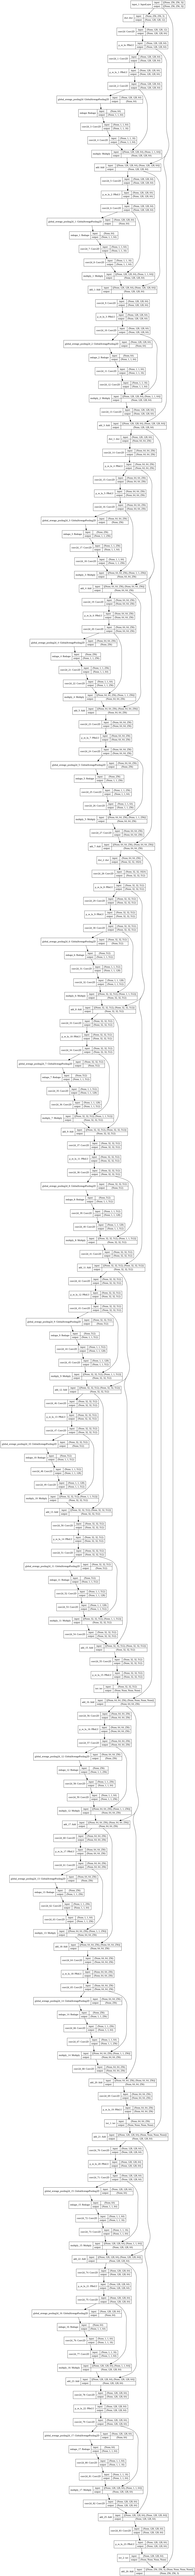

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
plot_model(model=model, to_file='mwrcanet.png', show_shapes=True)

### Model architecture ends here

#### Data Augmentaion

In [ ]:
#https://www.programcreek.com/python/example/102126/numpy.rot90
def data_aug(img, mode=0):
    '''
    function for data augmentation
    '''
    if mode == 0:
        return img
    elif mode == 1:
        return np.flipud(img)
    elif mode == 2:
        return np.rot90(img)
    elif mode == 3:
        return np.flipud(np.rot90(img))
    elif mode == 4:
        return np.rot90(img, k=2)
    elif mode == 5:
        return np.flipud(np.rot90(img, k=2))
    elif mode == 6:
        return np.rot90(img, k=3)
    elif mode == 7:
        return np.flipud(np.rot90(img, k=3))

#### The below function sorts the list based alpha numeric order

In [ ]:
#https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir#:~:text=To%20sort%20the%20result%2C%20use,listdir(path))%20.&text=You%20can%20now%20use%20this,dirlist%20%3D%20sorted_alphanumeric(os.
import re
def sorted_alphanumeric(data):
    '''
    sorts the list based on alpha numeric values
    '''
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

#### Train  data generator

In [ ]:
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
#https://www.geeksforgeeks.org/difference-between-yield-and-return-in-python/#:~:text=Difference%20between%20Python%20yield%20and%20Return&text=Yield%20is%20generally%20used%20to,result%20to%20the%20caller%20statement.&text=Yield%20statement%20function%20is%20executed,where%20the%20function%20get%20paused.
#https://stackoverflow.com/questions/59380430/how-to-use-model-fit-which-supports-generators-after-fit-generator-deprecation#:#~:text=fit%20which%20supports%20generators%20(after%20fit_generator%20deprecation),-python%20tensorflow%20keras&text=training)%20is%20deprecated%20and%20will,for%20updating%3A%20Please%20use%20Model.
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
def generator(batch_size=2,epoch=450,steps_per_epoch=200):
  '''
  function for train data generator which is fed to model.fit in keras
  '''
  while(True):
        list_of_pictures1=sorted_alphanumeric(os.listdir(root_path+'/resized_train_clean/'))
        list_of_pictures2=sorted_alphanumeric(os.listdir(root_path+'/resized_train_noisy/'))
       
        clean_arrays=[]
        noisy_arrays=[]
        for i in range(len(list_of_pictures1)):
                
                clean_array = img_to_array(load_img(root_path+'/resized_train_clean/'+list_of_pictures1[i]))/255
                noisy_array = img_to_array(load_img(root_path+'/resized_train_noisy/'+list_of_pictures2[i]))/255
                clean_arrays.append(clean_array)
                noisy_arrays.append(noisy_array)
                for k in range(3):
                  ran=np.random.randint(0,8)
                  clean_array=data_aug(clean_array,mode=ran)
                  noisy_array=data_aug(noisy_array,mode=ran)
                  clean_arrays.append(clean_array)
                  noisy_arrays.append(noisy_array)
        clean_arrays = np.array(clean_arrays).astype('float32')
        noisy_arrays = np.array(noisy_arrays).astype('float32')
        indices=list(range(clean_arrays.shape[0]))
        
        i=0
        for _ in range(epoch):
          np.random.shuffle(indices)    # shuffle
          while(i<clean_arrays.shape[0]):
            batch_clean_arrays = clean_arrays[indices[i:i+batch_size]]
            batch_noisy_arrays = noisy_arrays[indices[i:i+batch_size]]
            i=i+batch_size
            yield batch_noisy_arrays,batch_clean_arrays

### Test data generator 

In [ ]:
def test_generator(batch_size=2,epoch=3,steps_per_epoch=6):
  '''
  function for test data generator which is fed to model.fit in keras
  '''
  while(True):
        list_of_pictures1=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))
        list_of_pictures2=sorted_alphanumeric(os.listdir(root_path+'/resized_test_noisy/'))
       
        clean_arrays=[]
        noisy_arrays=[]
        for i in range(len(list_of_pictures1)):
                
                clean_array = img_to_array(load_img(root_path+'/resized_test_clean/'+list_of_pictures1[i]))/255
                noisy_array = img_to_array(load_img(root_path+'/resized_test_noisy/'+list_of_pictures2[i]))/255
                clean_arrays.append(clean_array)
                noisy_arrays.append(noisy_array)
                for k in range(6):
                  ran=np.random.randint(0,8)
                  clean_array=data_aug(clean_array,mode=ran)
                  noisy_array=data_aug(noisy_array,mode=ran)
                  clean_arrays.append(clean_array)
                  noisy_arrays.append(noisy_array)
        clean_arrays = np.array(clean_arrays).astype('float32')
        noisy_arrays = np.array(noisy_arrays).astype('float32')
        indices=list(range(clean_arrays.shape[0]))
        
        i=0
        for _ in range(epoch):
          np.random.shuffle(indices)    # shuffle
          while(i<clean_arrays.shape[0]):
            batch_clean_arrays = clean_arrays[indices[i:i+batch_size]]
            batch_noisy_arrays = noisy_arrays[indices[i:i+batch_size]]
            i=i+batch_size
            yield batch_noisy_arrays,batch_clean_arrays

### Custom loss function 

In [ ]:
#https://www.kdnuggets.com/2019/04/advanced-keras-constructing-complex-custom-losses-metrics.html
def sum_squared_error(y_true, y_pred):
    #return K.mean(K.square(y_pred - y_true), axis=-1)
    #return K.sum(K.square(y_pred - y_true), axis=-1)/2
    return K.sum(K.square(y_pred - y_true))/2

#### Loading last epoch model where last interruption occured. This loaded model remebers the last epoch executed and starts from there

In [ ]:
#https://stackoverflow.com/questions/52476191/what-does-initial-epoch-in-keras-mean/52478034#:~:text=initial_epoch%3A%20Integer.,if%20I'm%20wrong).
def initial_epochs():
  '''
  This function understands till what epoch model has executed untill last interuption happened
  ''' 
  list_of_epochs=[]
  filepaths=glob.glob('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_rca/*')
  if(not filepaths):
    return 0
  for path in filepaths:
    splitted=path.split('epochs')[1]
    epoch_num=int(splitted.split('.')[0])
    list_of_epochs.append(epoch_num)
  last_epoch=max(list_of_epochs)
  return last_epoch

In [ ]:
#https://stackoverflow.com/questions/52476191/what-does-initial-epoch-in-keras-mean/52478034#:~:text=initial_epoch%3A%20Integer.,if%20I'm%20wrong).
initial_epoch_ = initial_epochs()

In [ ]:
if(initial_epoch_>0):
  model=keras.models.load_model('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_rca/denoiser_epochs%03d.hdf5'%initial_epoch_,compile=False)

#### Compiling

In [ ]:
#compiling the model
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer = Adam(0.0001))

##### Set of keras callbacks

In [ ]:
#https://keras.io/api/callbacks/model_checkpoint/
#https://keras.io/api/callbacks/model_checkpoint/
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
#https://keras.io/api/callbacks/reduce_lr_on_plateau/
#https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/#:~:text=Early%20stopping%20is%20a%20method,deep%20learning%20neural%20network%20models.
model_save=ModelCheckpoint(
    'drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_rca/denoiser_epochs{epoch:03d}.hdf5',
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="min",
    save_freq=int(2*150))
#https://keras.io/api/callbacks/learning_rate_scheduler/
'''def scheduler(epoch):
      
      changing initial learning rate for adams optimizer
      
      lri=0.00002
      if epoch < 270:
        lr=lri
        return lr
      elif (epoch <300):
        lr=0.000001
        return lr
      elif (epoch<350):
        lr=0.0000001
        return lr
      elif (epoch<400):
        lr=0.00000001
        return lr
      else:
        lr=0.00000001
        return lr
learning_rate_scheduler=tf.keras.callbacks.LearningRateScheduler(scheduler)'''
learning_rate_scheduler=ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.7,
    patience=8,
    verbose=1,
    mode="min",
    min_delta=0.0001,
    min_lr=1e-11
)

early_stopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=50,
    verbose=1,
    mode="min"
)

callbacklist=[model_save,learning_rate_scheduler,early_stopping]

#### Fitting the model

In [ ]:
model.fit(generator(2,150,300),validation_data=test_generator(2,3,6),verbose=1,steps_per_epoch=150, epochs=300,initial_epoch=initial_epoch_,callbacks=callbacklist,validation_steps=6,
    validation_batch_size=2)


Epoch 1/300
Tensor("model/dwt/strided_slice:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("model/dwt_1/strided_slice:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("model/dwt_2/strided_slice:0", shape=(None, 32, 32, 256), dtype=float32)
Tensor("model/dwt/strided_slice:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("model/dwt_1/strided_slice:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("model/dwt_2/strided_slice:0", shape=(None, 32, 32, 256), dtype=float32)
150/150 [==============================] - ETA: 0s - loss: 0.0033Tensor("model/dwt/strided_slice:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("model/dwt_1/strided_slice:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("model/dwt_2/strided_slice:0", shape=(None, 32, 32, 256), dtype=float32)
150/150 [==============================] - 34s 125ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 2/300
150/150 [==============================] - 20s 137ms/step - loss: 8.8235e-04 - val_loss: 0.0027
Epoch 3/300


KeyboardInterrupt: ignored

In [ ]:
model.fit(generator(2,150,300),validation_data=test_generator(2,3,6),verbose=1,steps_per_epoch=150, epochs=300,initial_epoch=initial_epoch_,callbacks=callbacklist,validation_steps=6,
    validation_batch_size=2)

Epoch 41/300
150/150 [==============================] - 133s 720ms/step - loss: 257.9189 - val_loss: 942.3837
Epoch 42/300
150/150 [==============================] - 107s 713ms/step - loss: 257.6308 - val_loss: 584.4603
Epoch 43/300
150/150 [==============================] - 107s 714ms/step - loss: 287.5992 - val_loss: 743.3417
Epoch 44/300
150/150 [==============================] - 107s 713ms/step - loss: 314.1657 - val_loss: 1050.5096
Epoch 45/300
150/150 [==============================] - 107s 714ms/step - loss: 288.9228 - val_loss: 820.3382
Epoch 46/300
150/150 [==============================] - 107s 715ms/step - loss: 357.0060 - val_loss: 782.0783
Epoch 47/300
150/150 [==============================] - 107s 714ms/step - loss: 259.8101 - val_loss: 749.5176
Epoch 48/300
150/150 [==============================] - 107s 714ms/step - loss: 271.2988 - val_loss: 938.5135

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.1199999971722718e-05.
Epoch 49/300
150/150 [===============

In [ ]:
model.fit(generator(2,150,300),validation_data=test_generator(2,3,6),verbose=1,steps_per_epoch=150, epochs=300,initial_epoch=initial_epoch_,callbacks=callbacklist,validation_steps=6,
    validation_batch_size=2)

Epoch 61/300
150/150 [==============================] - 112s 719ms/step - loss: 344.5250 - val_loss: 819.6236
Epoch 62/300
150/150 [==============================] - 107s 714ms/step - loss: 297.1434 - val_loss: 799.2737
Epoch 63/300
150/150 [==============================] - 107s 714ms/step - loss: 261.0808 - val_loss: 748.7897
Epoch 64/300
150/150 [==============================] - 107s 714ms/step - loss: 291.9660 - val_loss: 888.3855
Epoch 65/300
150/150 [==============================] - 107s 714ms/step - loss: 251.3489 - val_loss: 686.2922
Epoch 66/300
150/150 [==============================] - 107s 715ms/step - loss: 226.2035 - val_loss: 750.4959
Epoch 67/300
150/150 [==============================] - 107s 714ms/step - loss: 238.4922 - val_loss: 776.8757
Epoch 68/300
150/150 [==============================] - 107s 714ms/step - loss: 227.7469 - val_loss: 763.1638
Epoch 69/300
150/150 [==============================] - 113s 757ms/step - loss: 251.2158 - val_loss: 749.7393
Epoch 70/3

In [ ]:
model.fit(generator(2,150,300),validation_data=test_generator(2,3,6),verbose=1,steps_per_epoch=150, epochs=300,initial_epoch=initial_epoch_,callbacks=callbacklist,validation_steps=6,
    validation_batch_size=2)

Epoch 101/300
150/150 [==============================] - 111s 718ms/step - loss: 241.7309 - val_loss: 720.1472
Epoch 102/300
150/150 [==============================] - 108s 718ms/step - loss: 285.8164 - val_loss: 935.3294
Epoch 103/300
150/150 [==============================] - 107s 715ms/step - loss: 229.7507 - val_loss: 744.3613
Epoch 104/300
150/150 [==============================] - 107s 714ms/step - loss: 247.8645 - val_loss: 891.7097
Epoch 105/300
150/150 [==============================] - 107s 714ms/step - loss: 224.7757 - val_loss: 790.3683
Epoch 106/300
150/150 [==============================] - 107s 715ms/step - loss: 225.6889 - val_loss: 676.7801
Epoch 107/300
150/150 [==============================] - 107s 715ms/step - loss: 225.2496 - val_loss: 734.5473
Epoch 108/300
150/150 [==============================] - 107s 715ms/step - loss: 268.1677 - val_loss: 839.7872
Epoch 109/300
150/150 [==============================] - 114s 761ms/step - loss: 228.4576 - val_loss: 859.9790
E

In [ ]:
model.fit(generator(2,150,300),validation_data=test_generator(2,3,6),verbose=1,steps_per_epoch=150, epochs=300,initial_epoch=initial_epoch_,callbacks=callbacklist,validation_steps=6,
    validation_batch_size=2)

Epoch 133/300
150/150 [==============================] - 120s 721ms/step - loss: 347.7181 - val_loss: 618.6488
Epoch 134/300
150/150 [==============================] - 107s 713ms/step - loss: 416.7129 - val_loss: 653.3575
Epoch 135/300
150/150 [==============================] - 107s 713ms/step - loss: 324.2347 - val_loss: 822.2484
Epoch 136/300
150/150 [==============================] - 107s 713ms/step - loss: 340.7371 - val_loss: 827.2526
Epoch 137/300
150/150 [==============================] - 107s 713ms/step - loss: 288.6069 - val_loss: 1067.6200
Epoch 138/300
150/150 [==============================] - 107s 715ms/step - loss: 262.5546 - val_loss: 654.9592
Epoch 139/300
150/150 [==============================] - 107s 713ms/step - loss: 268.3597 - val_loss: 904.6385

Epoch 00139: ReduceLROnPlateau reducing learning rate to 6.999999823165126e-05.
Epoch 140/300
150/150 [==============================] - 107s 713ms/step - loss: 271.7027 - val_loss: 740.9287
Epoch 141/300
150/150 [=======

In [ ]:
model.fit(generator(2,150,300),validation_data=test_generator(2,3,6),verbose=1,steps_per_epoch=150, epochs=300,initial_epoch=initial_epoch_,callbacks=callbacklist,validation_steps=6,
    validation_batch_size=2)

Epoch 173/300
150/150 [==============================] - 111s 717ms/step - loss: 167.8308 - val_loss: 836.8989
Epoch 174/300
150/150 [==============================] - 107s 714ms/step - loss: 231.6018 - val_loss: 615.0866
Epoch 175/300
150/150 [==============================] - 107s 713ms/step - loss: 283.0457 - val_loss: 755.8738
Epoch 176/300
150/150 [==============================] - 107s 713ms/step - loss: 226.6280 - val_loss: 776.3911
Epoch 177/300
150/150 [==============================] - 107s 713ms/step - loss: 217.5360 - val_loss: 835.1183
Epoch 178/300
150/150 [==============================] - 107s 714ms/step - loss: 181.5318 - val_loss: 848.5491
Epoch 179/300
150/150 [==============================] - 107s 714ms/step - loss: 177.8859 - val_loss: 743.9141
Epoch 180/300
150/150 [==============================] - 107s 713ms/step - loss: 174.9932 - val_loss: 802.2499
Epoch 181/300
150/150 [==============================] - 113s 756ms/step - loss: 230.3822 - val_loss: 783.7712
E

### list of things tried with the above architecture.
<ul>
<li>
Used different initial learning rates for adams optimizer when used 0.0001 as learning rate result was changing abruptly with every epoch . Then changed this to 0.00001 stabilized the result 
</li>
<li>
Tried different loss function including custom ssim and custom psnr loss ,but these did not work well may be because of they work on image level . Only square loss worked well.
</li>
<li>
Initially it was overfitting then reduced the architecture complexity,introduced l2 normalization to both bias term and main part. Added dropouts which was helpful to reduce the overfitting little bit. 
</li>
<li>
Tried with different batch sizes . Batch size 3 showed better performance.
</li>
</ul>

#### Validating test data with PSNR score and SSIM score

In [ ]:
#model = keras.models.load_model(root_path+'/model_mrdn2/'+'denoiser_epochs087.hdf5',compile=False)
list_clean=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))
list_noisy=sorted_alphanumeric(os.listdir(root_path+'/resized_test_noisy/'))
psnr_clean_noisy=[]
ssim_clean_noisy=[]
psnr_clean_predicted=[]
ssim_clean_predicted=[]
for file in tqdm(list_clean):
  clean = img_to_array(load_img(root_path+'/resized_test_clean/'+file))
  noisy = img_to_array(load_img(root_path+'/resized_test_noisy/'+file))
  image_predicted = model.predict(np.expand_dims(noisy/255,axis=0))
  predicted=img_to_array(array_to_img(image_predicted[0]))
  psnr_clean_noisy.append(peak_signal_noise_ratio(clean,noisy,data_range=255))
  ssim_clean_noisy.append(structural_similarity(clean,noisy,data_range=255,multichannel=True))
  psnr_clean_predicted.append(peak_signal_noise_ratio(clean,predicted,data_range=255))
  ssim_clean_predicted.append(structural_similarity(clean,predicted,data_range=255,multichannel=True))
length=len(list_clean)
psnr_clean_noisy_avg=sum(psnr_clean_noisy)/length
ssim_clean_noisy_avg=sum(ssim_clean_noisy)/length
psnr_clean_predicted_avg=sum(psnr_clean_predicted)/length
ssim_clean_predicted_avg=sum(ssim_clean_predicted)/length

Tensor("model/dwt/strided_slice:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("model/dwt_1/strided_slice:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("model/dwt_2/strided_slice:0", shape=(None, 32, 32, 256), dtype=float32)



In [ ]:
print('Clean and noisy images average psnr=',psnr_clean_noisy_avg)
print('Clean and noisy images average ssim=',ssim_clean_noisy_avg)
print('Clean and predicted image average psnr=',psnr_clean_predicted_avg)
print('Clean and predicted image average  ssim=',ssim_clean_predicted_avg)

Clean and noisy images average psnr= 25.871077011537334
Clean and noisy images average ssim= 0.7576541935709098
Clean and predicted image average psnr= 25.902048270555564
Clean and predicted image average  ssim= 0.757527769288519


In [ ]:
list_clean=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))
length=len(list_clean)

psnr_clean_noisy=[]
ssim_clean_noisy=[]

for file in os.listdir('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_rca/'):
  model=keras.models.load_model('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_rca/'+file,compile=False,custom_objects={"dwt": dwt,'iwt':iwt})
  print('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_rca/'+file)
  psnr_clean_predicted=[]
  ssim_clean_predicted=[]
  for file in tqdm(list_clean):
    clean = img_to_array(load_img(root_path+'/resized_test_clean/'+file))
    noisy = img_to_array(load_img(root_path+'/resized_test_noisy/'+file))
    image_predicted = model.predict(np.expand_dims(noisy/255,axis=0))
    predicted=img_to_array(array_to_img(image_predicted[0]))
    psnr_clean_predicted.append(peak_signal_noise_ratio(clean,predicted,data_range=255))
    ssim_clean_predicted.append(structural_similarity(clean,predicted,data_range=255,multichannel=True))
  psnr_clean_predicted_avg=sum(psnr_clean_predicted)/length
  print(psnr_clean_predicted_avg)
  ssim_clean_predicted_avg=sum(ssim_clean_predicted)/length
  print(ssim_clean_predicted_avg)

Tensor("dwt/strided_slice:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("dwt_1/strided_slice:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("dwt_2/strided_slice:0", shape=(None, 32, 32, 256), dtype=float32)
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_rca/denoiser_epochs002.hdf5


Tensor("model/dwt/strided_slice:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("model/dwt_1/strided_slice:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("model/dwt_2/strided_slice:0", shape=(None, 32, 32, 256), dtype=float32)

25.733065418884262
0.7556670078291987
Tensor("dwt/strided_slice:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("dwt_1/strided_slice:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("dwt_2/strided_slice:0", shape=(None, 32, 32, 256), dtype=float32)
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_rca/denoiser_epochs004.hdf5


Tensor("model/dwt/strided_slice:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("model/dwt_1/strided_slice:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("model/dwt_2/strided_slice:0", shape=(None, 32, 32, 256), dtype=float32)

25.852534426207512
0.7577404946934843
Tensor("dwt/strided_slice:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("dwt_1/strided_slice:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("dwt_2/strided_slice:0", shape=(None, 32, 32, 256), dtype=float32)
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_rca/denoiser_epochs006.hdf5


Tensor("model/dwt/strided_slice:0", shape=(None, 128, 128, 3), dtype=float32)
Tensor("model/dwt_1/strided_slice:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("model/dwt_2/strided_slice:0", shape=(None, 32, 32, 256), dtype=float32)

25.902048270555564
0.757527769288519


### Displaying images noisy ,clean and predicted

In [ ]:
#model = keras.models.load_model(root_path+'/model_mrdn2/'+'denoiser_epochs040.hdf5',compile=False)
list_clean=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))
list_noisy=sorted_alphanumeric(os.listdir(root_path+'/resized_test_noisy/'))
for file in list_clean[0:7]:
  image_clean=load_img(root_path+'/resized_test_clean/'+file,target_size=(256,256)) 
  image_noise=load_img(root_path+'/resized_test_noisy/'+file,target_size=(256,256))
  image_predicted = model.predict(np.expand_dims(img_to_array(image_noise)/255,axis=0))
  predicted_image = array_to_img(image_predicted[0])

  plt.figure(figsize=(16, 12))
  plt.subplot(131)
  plt.title('noisy image')
  plt.imshow(image_noise)

  plt.subplot(132)
  plt.title('clean image')
  plt.imshow(image_clean)

  plt.subplot(133)
  plt.title('predicted image')
  plt.imshow(predicted_image)

In [ ]:
#https://pypi.org/project/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["model", "psnr_clean_noisy", "psnr_clean_predicted",'psnr improvement from model', "ssim_clean_noisy",'ssim_clean_predicted','ssim improvement from model']
x.add_row(["baseline_DnCNN(8 data points taken)", 25.77 ,27.14   ,np.round(27.14 - 25.77,2), 0.7632 , 0.7793  ,np.round(0.7793-0.7632,3)])
x.add_row(["MRDN(10 datapoints taken)", np.round(psnr_clean_noisy_avg,2),np.round(psnr_clean_predicted_avg,2),np.round(psnr_clean_predicted_avg-psnr_clean_noisy_avg,2), np.round(ssim_clean_noisy_avg,4), np.round(ssim_clean_predicted_avg,4),np.round(ssim_clean_predicted_avg-ssim_clean_noisy_avg,4)])

print(x)

+-------------------------------------+------------------+----------------------+-----------------------------+------------------+----------------------+-----------------------------+
|                model                | psnr_clean_noisy | psnr_clean_predicted | psnr improvement from model | ssim_clean_noisy | ssim_clean_predicted | ssim improvement from model |
+-------------------------------------+------------------+----------------------+-----------------------------+------------------+----------------------+-----------------------------+
| baseline_DnCNN(8 data points taken) |      25.77       |        27.14         |             1.37            |      0.7632      |        0.7793        |            0.016            |
|      MRDN(10 datapoints taken)      |      24.71       |        27.58         |             2.87            |       0.71       |        0.8005        |            0.0906           |
+-------------------------------------+------------------+----------------------

### Conclusion and final points: MRDN model is showing better improvements interms of ssim and psnr compared to baseline_DnCNN like model. In the actual competion Samsung team trains MRDN model for 7 days and on large number of data. As I have limited resources trained it on 633 different data points and applied  image augmentation on it. Trained it for 3 to 4 hours. I feel that there is goood improvements interms of SSIM value compared to PSNR.

In [ ]:
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
#https://www.geeksforgeeks.org/difference-between-yield-and-return-in-python/#:~:text=Difference%20between%20Python%20yield%20and%20Return&text=Yield%20is%20generally%20used%20to,result%20to%20the%20caller%20statement.&text=Yield%20statement%20function%20is%20executed,where%20the%20function%20get%20paused.
#https://stackoverflow.com/questions/59380430/how-to-use-model-fit-which-supports-generators-after-fit-generator-deprecation#:#~:text=fit%20which%20supports%20generators%20(after%20fit_generator%20deprecation),-python%20tensorflow%20keras&text=training)%20is%20deprecated%20and%20will,for%20updating%3A%20Please%20use%20Model.
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [ ]:
def Model_Creation():
  first_input=Input(shape=(256,256,3))

  #encoder3
  first=dwt()(first_input)
  inp=Conv2D(64,3,padding='same')(first)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  second=RCAB(inp,64,3,3)


  #encoder2
  out_dwt_second = dwt()(second)
  inp=Conv2D(256,3,padding='same')(out_dwt_second)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  third=RCAB(inp,256,3,3)

  #encoder1
  out_dwt_third=dwt()(third)
  inp=Conv2D(512,3,padding='same')(out_dwt_third)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  inp=RCAB(inp,512,3,3)


  #decoder1
  inp=RCAB(inp,512,3,3)
  inp=Conv2D(512,3,padding='same')(inp)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  inp=iwt()(inp)
  inp=Add()([third,inp])

  #decoder2
  inp=RCAB(inp,256,3,3)
  inp=Conv2D(256,3,padding='same')(inp)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  inp=iwt()(inp)
  inp=Add()([second,inp])


  #decoder3
  inp=RCAB(inp,64,3,3)
  inp=Conv2D(64,3,padding='same')(inp)
  inp=PReLU(alpha_initializer='he_normal')(inp)
  inp=iwt()(inp)
  out=Add()([first_input,inp])

  return Model(inputs=first_input,outputs=out)



